In [1]:
%cd ..

/home/ltorres/leo/tesis/cloud-classification/code


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torchvision.io import read_image
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from random import sample
import torch
import torch.nn as nn

In [15]:
from src.dataset import GCD
from src import config
from src import engine_gnn as engine
from src import utils

from src.models.old.initial_graphnets import GraphConvGNN, GATConvGNN

In [5]:
from sklearn.metrics import accuracy_score

In [6]:
device = config.DEVICE

#### Data loaders

In [7]:
path_train_images = utils.get_gcd_paths(config.DATA_DIR,'train')

In [8]:
train_dataset = GCD(path_train_images, resize=256)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=4,
        shuffle=True,
    )

In [26]:
path_test_images = utils.get_gcd_paths(config.DATA_DIR,'test')

test_dataset = GCD(path_test_images, resize=256)

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=4,
        shuffle=True,
    )

### Data augmentation data loaders

In [10]:
augmentation_datasets = [
    GCD(utils.random_sample(path_train_images), resize=256, aug_types= atype)
    for atype in config.AUGMENTATION_TYPES
    ]

In [11]:
augmentation_loaders = [
    torch.utils.data.DataLoader(
            aug_dataset,
            batch_size=config.BATCH_SIZE,
            num_workers=4,
            shuffle=True,
        )
for aug_dataset in augmentation_datasets
]

#### Model

In [12]:
from torchvision import models

In [17]:
torch.cuda.empty_cache()

In [18]:
model = GATConvGNN(7).to(config.DEVICE)

In [12]:
#criterion = nn.CrossEntropyLoss()
criterion = utils.loge_loss
#optimizer  = torch.optim.Adam(model.parameters(), lr=3e-4)
optimizer  = torch.optim.SGD(model.parameters(), lr=3e-4, momentum=0.9)

In [13]:
model_filename = '/gcd_gnn/1_GATConvGNN_LOGE_SGD_27_03_22.pt'

### Train

In [17]:
best_accuracy=0
best_iteration=0
best_params={}

for e in range(config.EPOCHS):
    ### TRAIN DATASET
    preds, targets, loss = engine.train_fn(model, train_loader, criterion, optimizer, device=device)
    train_acc = accuracy_score(targets, preds)
    
    ### AUGMENTATION IMAGES
    for _loader in augmentation_loaders:
        engine.forward_backward_pass(model, _loader, criterion, optimizer, device=device)
    
    test_preds, test_targets, test_loss = engine.eval_fn(model, test_loader, criterion, device=device)
    test_acc = accuracy_score(test_targets, test_preds)
    
    if test_acc > best_accuracy:
        torch.save(model.state_dict(), config.SAVE_PATH+model_filename)
        print(f"Saved best parameters at epoch {e+1}")
        best_accuracy = test_acc
        best_iteration = e+1
        best_params = model.state_dict()
    
    print("EPOCH {}: Train acc: {:.2%} Train Loss: {:.4f} Test acc: {:.2%} Test Loss: {:.4f}".format(
        e+1,
        train_acc,
        loss,
        test_acc,
        test_loss
    ))


100%|██████████| 282/282 [00:17<00:00, 16.26it/s]


Saved best parameters at epoch 1
EPOCH 1: Train acc: 65.14% Train Loss: 2.0851 Test acc: 78.53% Test Loss: 1.3435


100%|██████████| 282/282 [00:17<00:00, 16.24it/s]


Saved best parameters at epoch 2
EPOCH 2: Train acc: 87.75% Train Loss: 0.7414 Test acc: 80.62% Test Loss: 1.2869


100%|██████████| 282/282 [00:17<00:00, 16.20it/s]


Saved best parameters at epoch 3
EPOCH 3: Train acc: 90.50% Train Loss: 0.5786 Test acc: 80.98% Test Loss: 1.2251


100%|██████████| 282/282 [00:17<00:00, 16.20it/s]


EPOCH 4: Train acc: 92.42% Train Loss: 0.4575 Test acc: 79.68% Test Loss: 1.3246


100%|██████████| 282/282 [00:17<00:00, 16.16it/s]


EPOCH 5: Train acc: 93.95% Train Loss: 0.3801 Test acc: 80.07% Test Loss: 1.2853


100%|██████████| 282/282 [00:17<00:00, 16.09it/s]


EPOCH 6: Train acc: 94.75% Train Loss: 0.3264 Test acc: 79.46% Test Loss: 1.3158


100%|██████████| 282/282 [00:17<00:00, 16.17it/s]


EPOCH 7: Train acc: 95.55% Train Loss: 0.2837 Test acc: 78.42% Test Loss: 1.4053


100%|██████████| 282/282 [00:17<00:00, 16.15it/s]


EPOCH 8: Train acc: 96.30% Train Loss: 0.2342 Test acc: 80.34% Test Loss: 1.3403


100%|██████████| 282/282 [00:17<00:00, 16.11it/s]


EPOCH 9: Train acc: 97.20% Train Loss: 0.1842 Test acc: 79.30% Test Loss: 1.3707


100%|██████████| 282/282 [00:17<00:00, 16.14it/s]


EPOCH 10: Train acc: 97.49% Train Loss: 0.1632 Test acc: 78.90% Test Loss: 1.3969


100%|██████████| 282/282 [00:17<00:00, 16.19it/s]


EPOCH 11: Train acc: 98.25% Train Loss: 0.1307 Test acc: 80.01% Test Loss: 1.3570


100%|██████████| 282/282 [00:17<00:00, 16.25it/s]


EPOCH 12: Train acc: 98.47% Train Loss: 0.1110 Test acc: 80.18% Test Loss: 1.3804


100%|██████████| 282/282 [00:17<00:00, 16.23it/s]


EPOCH 13: Train acc: 98.51% Train Loss: 0.1014 Test acc: 79.49% Test Loss: 1.4196


100%|██████████| 282/282 [00:17<00:00, 16.14it/s]


EPOCH 14: Train acc: 99.11% Train Loss: 0.0698 Test acc: 80.09% Test Loss: 1.3489


100%|██████████| 282/282 [00:17<00:00, 16.19it/s]


EPOCH 15: Train acc: 99.11% Train Loss: 0.0700 Test acc: 80.66% Test Loss: 1.3808


100%|██████████| 282/282 [00:17<00:00, 16.24it/s]


EPOCH 16: Train acc: 99.13% Train Loss: 0.0653 Test acc: 79.99% Test Loss: 1.4061


100%|██████████| 282/282 [00:17<00:00, 16.20it/s]


EPOCH 17: Train acc: 99.19% Train Loss: 0.0581 Test acc: 80.96% Test Loss: 1.3616


100%|██████████| 282/282 [00:17<00:00, 16.21it/s]


EPOCH 18: Train acc: 99.40% Train Loss: 0.0490 Test acc: 80.13% Test Loss: 1.3814


100%|██████████| 282/282 [00:17<00:00, 16.24it/s]


EPOCH 19: Train acc: 99.41% Train Loss: 0.0485 Test acc: 80.53% Test Loss: 1.3862


100%|██████████| 282/282 [00:17<00:00, 16.22it/s]


Saved best parameters at epoch 20
EPOCH 20: Train acc: 99.40% Train Loss: 0.0501 Test acc: 82.73% Test Loss: 1.2270


100%|██████████| 282/282 [00:17<00:00, 16.06it/s]


EPOCH 21: Train acc: 99.56% Train Loss: 0.0368 Test acc: 79.41% Test Loss: 1.4376


100%|██████████| 282/282 [00:17<00:00, 16.10it/s]


EPOCH 22: Train acc: 99.65% Train Loss: 0.0335 Test acc: 79.64% Test Loss: 1.4074


100%|██████████| 282/282 [00:17<00:00, 16.16it/s]


EPOCH 23: Train acc: 99.65% Train Loss: 0.0282 Test acc: 82.17% Test Loss: 1.2762


100%|██████████| 282/282 [00:17<00:00, 16.21it/s]


EPOCH 24: Train acc: 99.71% Train Loss: 0.0255 Test acc: 79.69% Test Loss: 1.4248


100%|██████████| 282/282 [00:17<00:00, 16.20it/s]


EPOCH 25: Train acc: 99.65% Train Loss: 0.0272 Test acc: 81.52% Test Loss: 1.3352


In [19]:
model.load_state_dict(torch.load(config.SAVE_PATH+model_filename))

<All keys matched successfully>

In [27]:
test_preds, test_targets, test_loss = engine.eval_fn(model, test_loader, criterion, device=device)

100%|██████████| 282/282 [00:17<00:00, 16.28it/s]


In [28]:
accuracy_score(test_targets, test_preds)

0.7514444444444445

---

### Accuracy per class and confusion matrix

In [29]:
class_mapper = {
    0: '1_cumulus',
    1: '2_altocumulus',
    2: '3_cirrus',
    3: '4_clearsky',
    4: '5_stratocumulus',
    5: '6_cumulonimbus',
    6: '7_mixed',
}

In [30]:
class_acc = dict()
matrix = np.zeros((7,7), dtype=int)

for i in range(7):
    pred_index = np.where(test_targets==i)[0]
    class_acc[class_mapper[i]] = accuracy_score(test_targets[pred_index], test_preds[pred_index])
    
    for j in test_preds[pred_index]:
        matrix[i,j]+=1 

In [31]:
class_acc

{'1_cumulus': 0.6866666666666666,
 '2_altocumulus': 0.39066666666666666,
 '3_cirrus': 0.7888446215139442,
 '4_clearsky': 0.9565764631843927,
 '5_stratocumulus': 0.6810055865921788,
 '6_cumulonimbus': 0.8134733792104311,
 '7_mixed': 0.6194398682042833}

Global Test accuracy 0.7514444444444445


<AxesSubplot:title={'center':'Confusion Matrix (Accuracy %)'}>

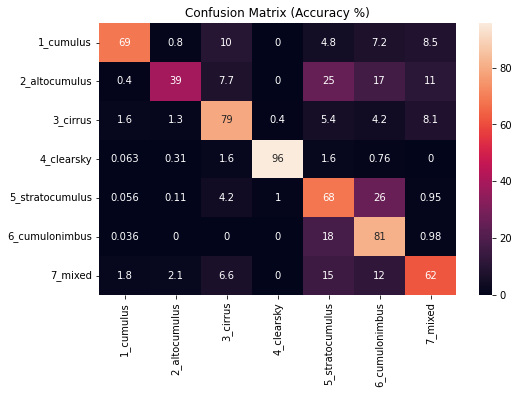

In [32]:
print(f"Global Test accuracy {accuracy_score(test_targets, test_preds)}")

sum_of_rows = matrix.sum(axis=1)
conf_mat = 100*matrix / sum_of_rows[:, np.newaxis]

df_cm = pd.DataFrame(conf_mat, index = class_acc.keys(),
                  columns = class_acc.keys())

plt.figure(figsize = (8,5))
plt.title("Confusion Matrix (Accuracy %)")
sns.heatmap(df_cm, annot=True)